In [35]:
import numpy as np
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM 
from sklearn.metrics import mean_absolute_error

In [36]:
df = pd.read_csv('ASII_stock_combined.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')
print(f"Jumlah Baris = {df.shape[0]}")
df.head()

Jumlah Baris = 1374


,open,low,high,close,volume
timestamp,,,,,
2019-01-01,8225,8225,8225,8225,0
2019-01-02,8200,8125,8275,8200,14014100
2019-01-03,8100,8100,8400,8375,25148400
2019-01-04,8400,8200,8450,8350,32475900
2019-01-07,8450,8150,8475,8150,32649700


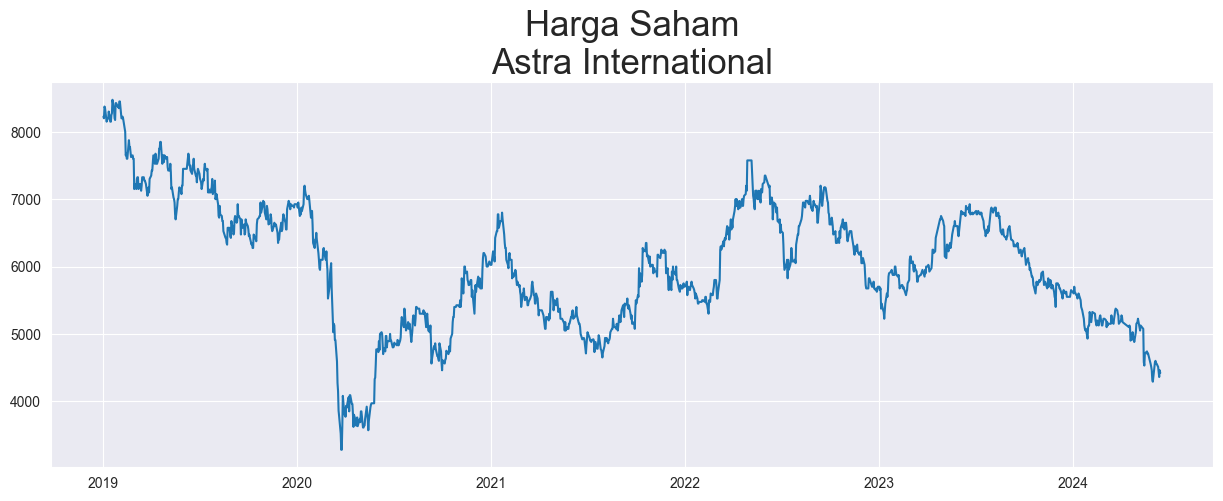

In [37]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
plt.plot(df.index, df['close'])
plt.title("Harga Saham\nAstra International", fontsize=25)
plt.show()

In [38]:
ms = MinMaxScaler()
df['close'] = ms.fit_transform(df[['close']])

In [39]:
def split_data(df, train_size): 
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [40]:
train, test = split_data(df['close'], 0.8)

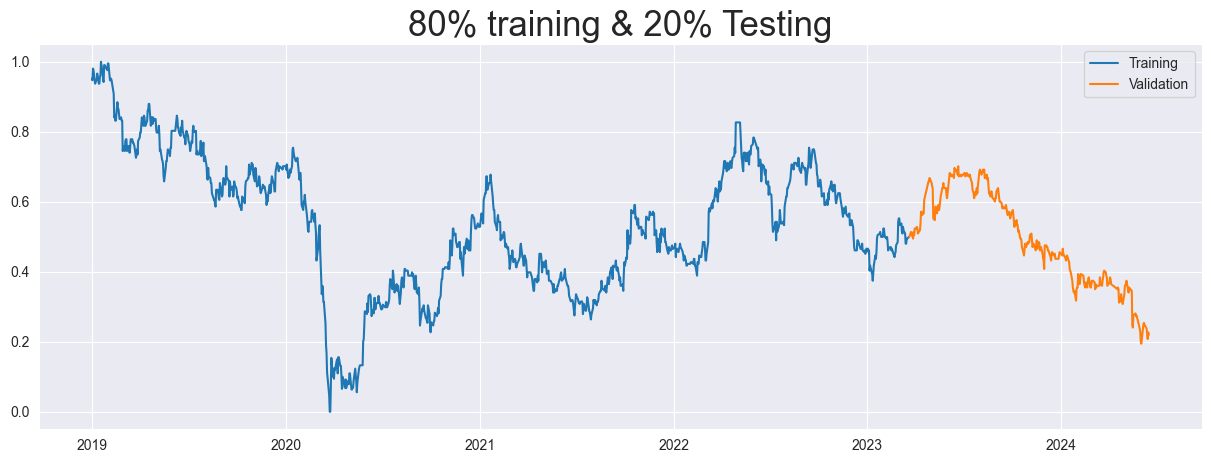

In [41]:
train, test = split_data(df['close'], 0.8) #80% Train
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Validation'])
plt.title('80% training & 20% Testing', fontsize=25)
plt.show()

In [42]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [43]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [44]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [45]:
model = Sequential([LSTM(100, input_shape=(1, 1), return_sequences=True),
                    LSTM(50), 
                    Dense(25, activation='relu'),
                    Dense(1)])

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())

In [47]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=400, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/400
9/9 [==============================] - 4s 84ms/step - loss: 0.1594 - mae: 0.5310 - val_loss: 0.1259 - val_mae: 0.4841
Epoch 2/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1560 - mae: 0.5248 - val_loss: 0.1231 - val_mae: 0.4783
Epoch 3/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1528 - mae: 0.5188 - val_loss: 0.1202 - val_mae: 0.4723
Epoch 4/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1495 - mae: 0.5127 - val_loss: 0.1173 - val_mae: 0.4662
Epoch 5/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1462 - mae: 0.5064 - val_loss: 0.1143 - val_mae: 0.4598
Epoch 6/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1428 - mae: 0.4999 - val_loss: 0.1113 - val_mae: 0.4532
Epoch 7/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1393 - mae: 0.4931 - val_loss: 0.1081 - val_mae: 0.4464
Epoch 8/400
9/9 [==============================] - 0s 7ms/step - loss: 0.1358 - mae: 0.4860 - va

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Membuat prediksi
y_pred = model.predict(X_test)

# Balik transformasi skala (jika diperlukan)
y_test_inv = ms.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = ms.inverse_transform(y_pred)

# Hitung metrik
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Tampilkan hasil
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

9/9 [==============================] - 1s 1ms/step
MAE: 67.91715435390051
MSE: 9237.888832033985
RMSE: 96.11393672113314
R2 Score: 0.9807400524931604


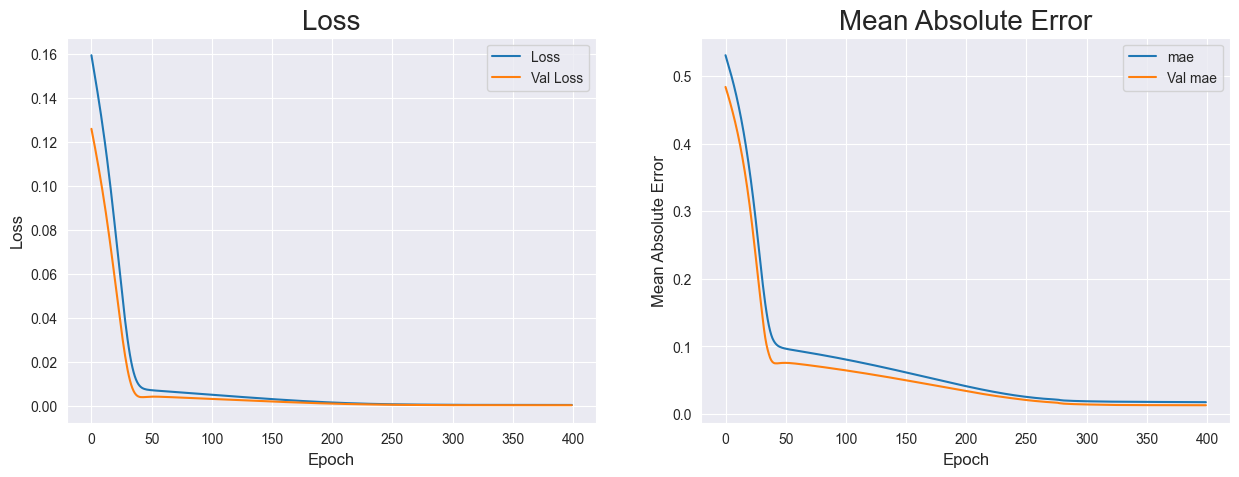

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

9/9 [==============================] - 0s 1ms/step


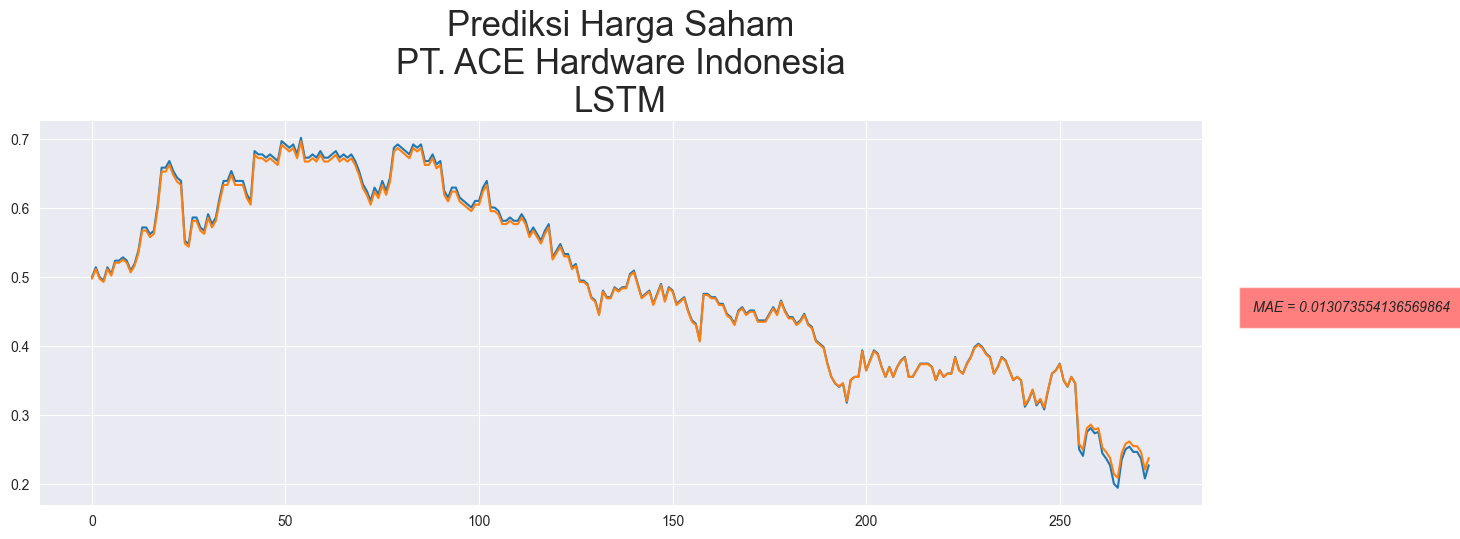

In [50]:
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.text(300, 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title('Prediksi Harga Saham\nPT. ACE Hardware Indonesia\nLSTM', fontsize=25)
plt.show()